File read successfully. Number of rows: 5565
Data structure:
root
 |-- Date: date (nullable = true)
 |-- Buy Price: float (nullable = true)
 |-- Sell Price: float (nullable = true)

Sample data:
+----------+---------+----------+
|      Date|Buy Price|Sell Price|
+----------+---------+----------+
|2009-08-01|    21.13|     21.19|
|2009-08-02|    21.13|     21.19|
|2009-08-03|    21.13|     21.19|
|2009-08-04|    21.13|     21.19|
|2009-08-05|    21.13|     21.19|
+----------+---------+----------+
only showing top 5 rows

Descriptive statistics of the data:
+-------+------------------+------------------+
|summary|         Buy Price|        Sell Price|
+-------+------------------+------------------+
|  count|              5565|              5565|
|   mean| 45.56569992812603|  46.0176676298623|
| stddev|14.892835070488525|15.353833647861233|
|    min|             21.13|             21.19|
|    max|              89.0|              91.3|
+-------+------------------+------------------+

Check

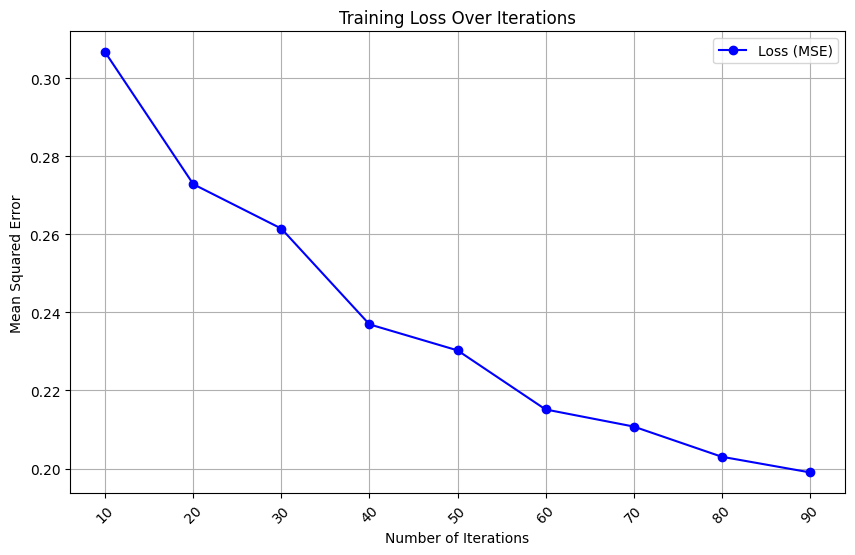

Evaluation results:
R2:
  Training: 0.9991
  Test: 0.9994
RMSE:
  Training: 0.4348
  Test: 0.3717
MAE:
  Training: 0.2116
  Test: 0.1885


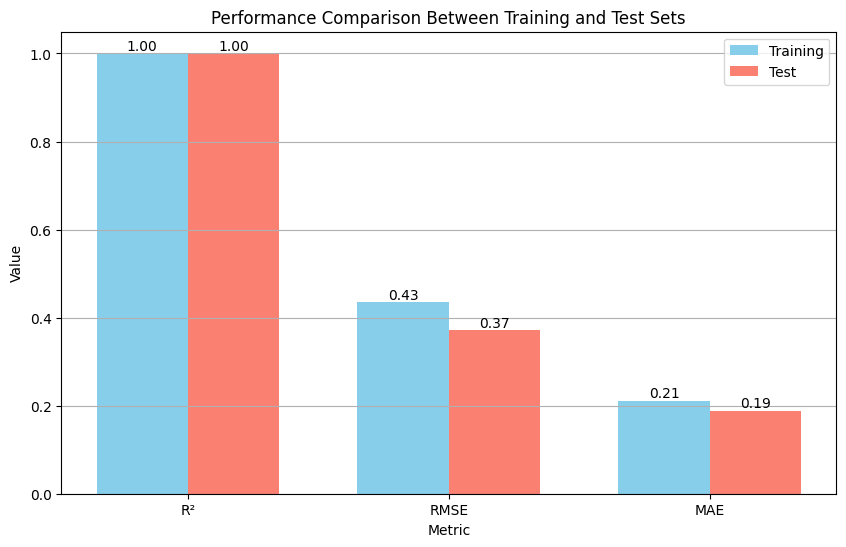

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, randn
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Create Spark session
spark = SparkSession.builder.appName("GoldPricePrediction").getOrCreate()

try:
    # 1. Read data from CSV file
    df = spark.read.csv("gold_prices.csv", header=True, inferSchema=True)
    print(f"File read successfully. Number of rows: {df.count()}")

    # Ensure correct data types
    df = df.withColumn("Date", col("Date").cast("date"))
    df = df.withColumn("Buy Price", col("Buy Price").cast("float"))
    df = df.withColumn("Sell Price", col("Sell Price").cast("float"))

    # Display data structure and sample data
    print("Data structure:")
    df.printSchema()
    print("Sample data:")
    df.show(5)

    # Descriptive statistics of the data
    print("Descriptive statistics of the data:")
    df.describe(["Buy Price", "Sell Price"]).show()

    # Check and print null values in the original data
    print("Checking for null values in the original data:")
    for column in df.columns:
        null_count = df.filter(col(column).isNull()).count()
        print(f"Column {column}: {null_count} null values")

    # Cache the DataFrame for optimization
    df.cache()

    # 2. Create lag features (buy prices from the previous 10 days)
    window = Window.orderBy("Date")
    for i in range(1, 11):
        df = df.withColumn(f"lag_{i}", lag("Buy Price", i).over(window))

    # Add small noise to increase variance
    for i in range(1, 11):
        df = df.withColumn(f"lag_{i}", col(f"lag_{i}") + randn() * 0.01)

    # Check and print rows with null values after creating lag columns
    print("\nRows containing null values after creating lag columns:")
    lag_columns = ["Date", "Buy Price"] + [f"lag_{i}" for i in range(1, 11)]

    # Print table manually
    header = "|".join([f" {col_name:<11}" for col_name in lag_columns])
    print(f"+{'-' * 12}+{'-' * 12}" + "+".join([f"{'-' * 12}" for _ in range(10)]) + "+")
    print(f"|{header}|")
    print(f"+{'-' * 12}+{'-' * 12}" + "+".join([f"{'-' * 12}" for _ in range(10)]) + "+")

    # Get the first 10 rows to display values
    sample_data = df.select(lag_columns).limit(10).collect()
    for row in sample_data:
        row_values = []
        for col_name in lag_columns:
            value = row[col_name]
            if value is None:
                row_values.append(f" {'NULL':<11}")
            else:
                if col_name == "Date":
                    row_values.append(f" {str(value):<11}")
                else:
                    # Format numbers with 2 decimal places
                    formatted_value = f"{float(value):.2f}"
                    row_values.append(f" {formatted_value:<11}")
        print(f"|{'|'.join(row_values)}|")
    print(f"+{'-' * 12}+{'-' * 12}" + "+".join([f"{'-' * 12}" for _ in range(10)]) + "+")

    # Remove rows with null values
    df = df.na.drop()
    print(f"Number of rows after removing nulls: {df.count()}")

    # 3. Assemble lag columns into a feature vector
    feature_cols = [f"lag_{i}" for i in range(1, 11)]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df = assembler.transform(df)

    # Standardize features
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
    scaler_model = scaler.fit(df)
    df = scaler_model.transform(df)

    # Check data after standardization
    print("Sample data after standardization:")
    df.select("scaled_features").show(5, truncate=False)

    # Select necessary columns: scaled_features and label (Buy Price)
    df = df.select("Date", "scaled_features", col("Buy Price").alias("label")).withColumnRenamed("scaled_features", "features")

    # Split data into training (70%) and test (30%) sets
    train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)
    print(f"Number of training samples: {train_df.count()}")
    print(f"Number of test samples: {test_df.count()}")

    # 4. Simulate training loss over iterations (maxIter)
    max_iters = list(range(10, 91, 10))  # From 10 to 90, step of 10: [10, 20, 30, ..., 90]
    losses = []
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
    for max_iter in max_iters:
        lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=max_iter, regParam=0.01, elasticNetParam=0.5, solver="l-bfgs")
        model = lr.fit(train_df)
        preds = model.transform(train_df)
        loss = evaluator.evaluate(preds)
        losses.append(loss)

    # Print training loss results before plotting
    print("Training loss (MSE) results over iterations:")
    for max_iter, loss in zip(max_iters, losses):
        print(f"maxIter: {max_iter}, MSE: {loss:.4f}")

    # Plot a line chart for training loss
    plt.figure(figsize=(10, 6))
    plt.plot(max_iters, losses, marker="o", color="blue", label="Loss (MSE)")
    plt.title("Training Loss Over Iterations")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Mean Squared Error")
    plt.xticks(max_iters, rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

    # 5. Train the final model
    lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.01, elasticNetParam=0.5, solver="l-bfgs")
    lr_model = lr.fit(train_df)

    # Evaluate the model
    train_predictions = lr_model.transform(train_df)
    test_predictions = lr_model.transform(test_df)

    # Calculate R2, RMSE, MAE metrics
    metrics = ["r2", "rmse", "mae"]
    results = {"train": [], "test": []}
    for metric in metrics:
        evaluator.setMetricName(metric)
        train_result = evaluator.evaluate(train_predictions)
        test_result = evaluator.evaluate(test_predictions)
        results["train"].append(train_result)
        results["test"].append(test_result)

    # Print evaluation results
    print("Evaluation results:")
    for i, metric in enumerate(metrics):
        print(f"{metric.upper()}:")
        print(f"  Training: {results['train'][i]:.4f}")
        print(f"  Test: {results['test'][i]:.4f}")

    # 6. Plot a bar chart comparing training and test performance
    bar_width = 0.35
    index = range(len(metrics))
    plt.figure(figsize=(10, 6))
    bars_train = plt.bar(index, results["train"], bar_width, label="Training", color="skyblue")
    bars_test = plt.bar([i + bar_width for i in index], results["test"], bar_width, label="Test", color="salmon")
    plt.xlabel("Metric")
    plt.ylabel("Value")
    plt.title("Performance Comparison Between Training and Test Sets")
    plt.xticks([i + bar_width / 2 for i in index], ["R²", "RMSE", "MAE"])
    plt.legend()
    plt.grid(True, axis="y")
    # Add values on top of bars
    for bar in bars_train:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')
    for bar in bars_test:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close Spark session
    spark.stop()